In [1]:
import cv2
import glob
import os
import torch
%matplotlib inline
import torch.nn as nn
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image_pil = Image.fromarray(image)
        if self.transform:
            image_pil = self.transform(image_pil)
        return image_pil

In [3]:
photo_directory = "/content/drive/MyDrive/New_all_ai/TEST_DATASET/Gan_Model_dataset"
photo_files = glob.glob(f"{photo_directory}/*.jpg")

In [4]:
imgs = []
for i in photo_files:
  img = cv2.imread(i)
  img = cv2.resize(img, (64,64))
  imgs.append(img)

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

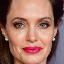

In [6]:
cv2_imshow(imgs[16])

In [7]:
transform = transforms.Compose([
                                transforms.Resize((image_size,image_size)),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)
                                ])

In [8]:
train_data = CustomDataset(imgs, transform=transform)

In [11]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
def denorm(img_tensor):
  return img_tensor * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


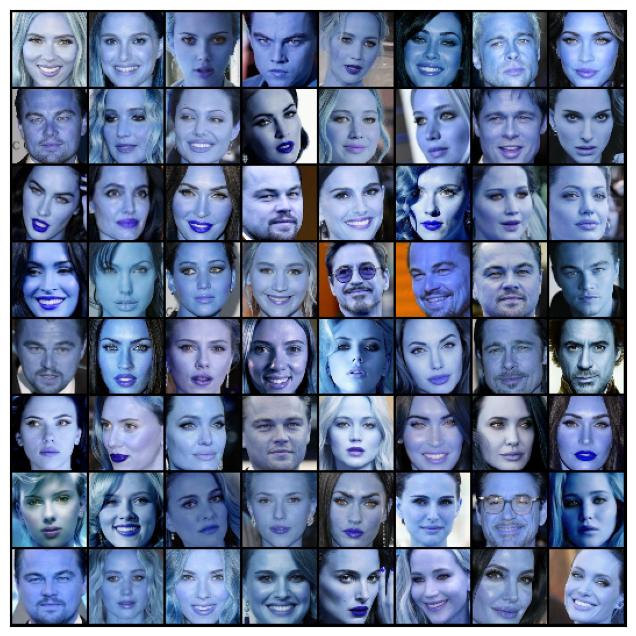

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoder():
  def __init__(self, dl, device):
    self.dl =dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoder(train_dl, device)

In [16]:
discriminator = nn.Sequential(
    #in: 3x64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # 64x32x32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # 128x16x16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # 256xx8x8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # 512x4x4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    # 1x1x1

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
summary(discriminator, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [20]:
latent_size = 128

In [29]:
generator = nn.Sequential(
    # latent_sizex1x1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # 512x4x4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # 256x8x8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # 128x16x16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # 64x32x32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # 3x64x64
)

In [31]:
generator = to_device(generator, device)

In [24]:
summary(generator, (128,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

torch.Size([128, 3, 64, 64])


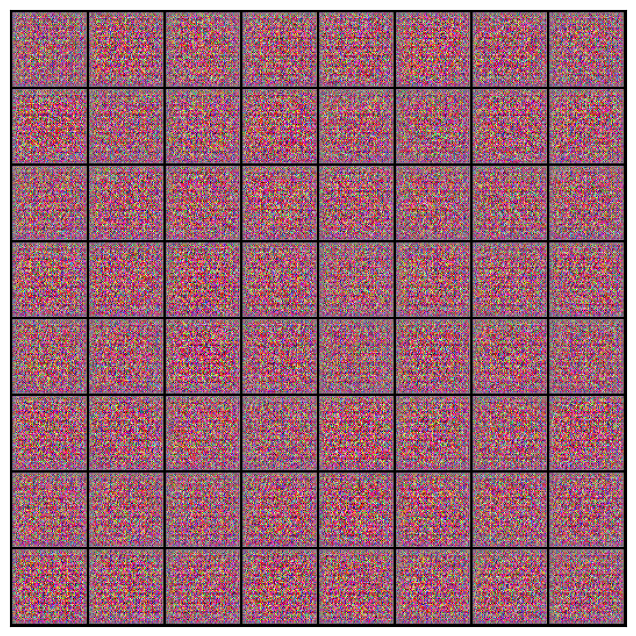

In [30]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [32]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()
    return loss.item()

In [33]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss= F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [34]:
sample_dir = '/content/drive/MyDrive/New_all_ai/Genrated'
os.makedirs(sample_dir, exist_ok=True)

In [43]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_2-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


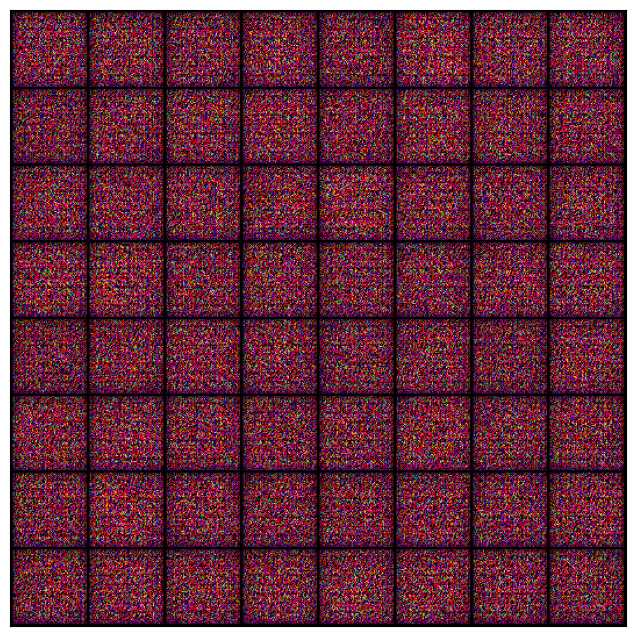

In [37]:
save_samples(0, fixed_latent)

In [38]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [44]:
lr = 0.0005
epochs = 50

In [45]:
history = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/50], loss_g: 1.8635, loss_d: 1.4464, real_score: 0.7182, fake_score: 0.5172
Saving generated_2-images-0001.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [2/50], loss_g: 3.7022, loss_d: 1.0282, real_score: 0.8143, fake_score: 0.4884
Saving generated_2-images-0002.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [3/50], loss_g: 3.9222, loss_d: 0.9343, real_score: 0.9142, fake_score: 0.5509
Saving generated_2-images-0003.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [4/50], loss_g: 4.3826, loss_d: 1.0763, real_score: 0.9459, fake_score: 0.6064
Saving generated_2-images-0004.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [5/50], loss_g: 6.3742, loss_d: 0.8795, real_score: 0.8786, fake_score: 0.4938
Saving generated_2-images-0005.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [6/50], loss_g: 3.7505, loss_d: 0.9057, real_score: 0.5712, fake_score: 0.0956
Saving generated_2-images-0006.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [7/50], loss_g: 3.1218, loss_d: 0.9142, real_score: 0.4770, fake_score: 0.0718
Saving generated_2-images-0007.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [8/50], loss_g: 2.2827, loss_d: 0.9381, real_score: 0.4949, fake_score: 0.1014
Saving generated_2-images-0008.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [9/50], loss_g: 2.7185, loss_d: 0.6221, real_score: 0.7296, fake_score: 0.2085
Saving generated_2-images-0009.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [10/50], loss_g: 5.5240, loss_d: 1.1726, real_score: 0.7615, fake_score: 0.5387
Saving generated_2-images-0010.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [11/50], loss_g: 3.5128, loss_d: 0.9199, real_score: 0.4747, fake_score: 0.0460
Saving generated_2-images-0011.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [12/50], loss_g: 2.9833, loss_d: 1.0718, real_score: 0.4530, fake_score: 0.0657
Saving generated_2-images-0012.png


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [13/50], loss_g: 4.9046, loss_d: 1.2902, real_score: 0.7509, fake_score: 0.5780
Saving generated_2-images-0013.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [14/50], loss_g: 4.1086, loss_d: 0.9449, real_score: 0.6365, fake_score: 0.3148
Saving generated_2-images-0014.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [15/50], loss_g: 1.7255, loss_d: 1.4639, real_score: 0.9071, fake_score: 0.7099
Saving generated_2-images-0015.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [16/50], loss_g: 2.4291, loss_d: 0.6574, real_score: 0.7419, fake_score: 0.2663
Saving generated_2-images-0016.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [17/50], loss_g: 5.0688, loss_d: 1.1323, real_score: 0.7879, fake_score: 0.5579
Saving generated_2-images-0017.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [18/50], loss_g: 3.6607, loss_d: 0.4835, real_score: 0.7202, fake_score: 0.1006
Saving generated_2-images-0018.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [19/50], loss_g: 3.5586, loss_d: 0.8156, real_score: 0.5963, fake_score: 0.1357
Saving generated_2-images-0019.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [20/50], loss_g: 2.5870, loss_d: 0.9866, real_score: 0.4719, fake_score: 0.0494
Saving generated_2-images-0020.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [21/50], loss_g: 5.5141, loss_d: 1.8134, real_score: 0.2110, fake_score: 0.0030
Saving generated_2-images-0021.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [22/50], loss_g: 3.9284, loss_d: 0.7628, real_score: 0.7192, fake_score: 0.3033
Saving generated_2-images-0022.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [23/50], loss_g: 3.2059, loss_d: 0.9847, real_score: 0.9626, fake_score: 0.5290
Saving generated_2-images-0023.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [24/50], loss_g: 3.3163, loss_d: 0.7555, real_score: 0.5490, fake_score: 0.0721
Saving generated_2-images-0024.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [25/50], loss_g: 3.0774, loss_d: 0.9479, real_score: 0.7951, fake_score: 0.4471
Saving generated_2-images-0025.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [26/50], loss_g: 3.4420, loss_d: 0.7435, real_score: 0.6300, fake_score: 0.1809
Saving generated_2-images-0026.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [27/50], loss_g: 3.6300, loss_d: 0.8565, real_score: 0.5589, fake_score: 0.0480
Saving generated_2-images-0027.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [28/50], loss_g: 3.6438, loss_d: 0.6324, real_score: 0.6914, fake_score: 0.1529
Saving generated_2-images-0028.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [29/50], loss_g: 2.7148, loss_d: 0.6577, real_score: 0.5861, fake_score: 0.0244
Saving generated_2-images-0029.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [30/50], loss_g: 5.2558, loss_d: 0.9765, real_score: 0.8529, fake_score: 0.5065
Saving generated_2-images-0030.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [31/50], loss_g: 3.1105, loss_d: 0.7863, real_score: 0.6551, fake_score: 0.2391
Saving generated_2-images-0031.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [32/50], loss_g: 5.9877, loss_d: 1.5554, real_score: 0.9622, fake_score: 0.7175
Saving generated_2-images-0032.png


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [33/50], loss_g: 4.7671, loss_d: 1.0110, real_score: 0.8580, fake_score: 0.5360
Saving generated_2-images-0033.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [34/50], loss_g: 2.1665, loss_d: 1.0247, real_score: 0.4802, fake_score: 0.1423
Saving generated_2-images-0034.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [35/50], loss_g: 3.3199, loss_d: 0.5810, real_score: 0.6599, fake_score: 0.0891
Saving generated_2-images-0035.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [36/50], loss_g: 3.7897, loss_d: 0.8486, real_score: 0.6990, fake_score: 0.3402
Saving generated_2-images-0036.png


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [37/50], loss_g: 4.3204, loss_d: 0.6261, real_score: 0.8114, fake_score: 0.2811
Saving generated_2-images-0037.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [38/50], loss_g: 2.1033, loss_d: 1.4577, real_score: 0.3197, fake_score: 0.0378
Saving generated_2-images-0038.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [39/50], loss_g: 2.6901, loss_d: 0.3859, real_score: 0.7892, fake_score: 0.1144
Saving generated_2-images-0039.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [40/50], loss_g: 4.9996, loss_d: 1.0409, real_score: 0.4292, fake_score: 0.0104
Saving generated_2-images-0040.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [41/50], loss_g: 4.5564, loss_d: 0.5683, real_score: 0.8275, fake_score: 0.2843
Saving generated_2-images-0041.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [42/50], loss_g: 2.6525, loss_d: 0.2456, real_score: 0.8655, fake_score: 0.0788
Saving generated_2-images-0042.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [43/50], loss_g: 4.6580, loss_d: 0.6843, real_score: 0.8707, fake_score: 0.3785
Saving generated_2-images-0043.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [44/50], loss_g: 5.4943, loss_d: 1.3092, real_score: 0.3238, fake_score: 0.0032
Saving generated_2-images-0044.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [45/50], loss_g: 3.9244, loss_d: 0.6154, real_score: 0.6767, fake_score: 0.1383
Saving generated_2-images-0045.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [46/50], loss_g: 4.7864, loss_d: 0.5574, real_score: 0.8628, fake_score: 0.3083
Saving generated_2-images-0046.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [47/50], loss_g: 9.2070, loss_d: 0.7938, real_score: 0.8966, fake_score: 0.4581
Saving generated_2-images-0047.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [48/50], loss_g: 2.8086, loss_d: 1.3507, real_score: 0.3479, fake_score: 0.0147
Saving generated_2-images-0048.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [49/50], loss_g: 2.1579, loss_d: 0.4245, real_score: 0.8217, fake_score: 0.1793
Saving generated_2-images-0049.png


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [50/50], loss_g: 5.6580, loss_d: 0.9985, real_score: 0.8882, fake_score: 0.5364
Saving generated_2-images-0050.png


In [46]:
losses_g, losses_d, real_scores, fake_scores = history

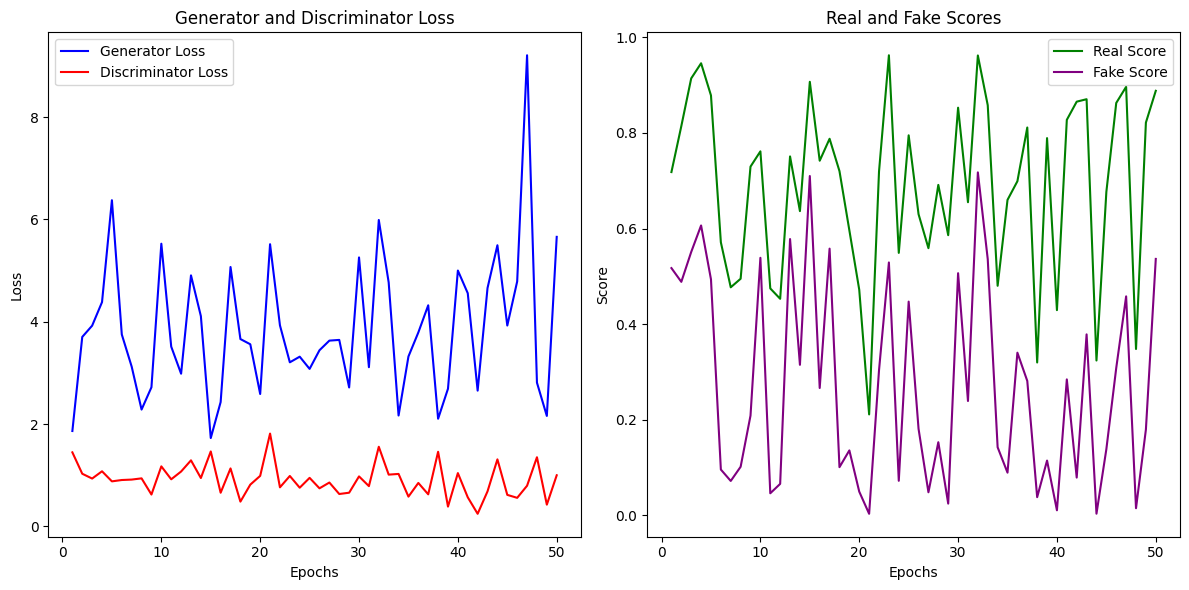

In [47]:
losses_g, losses_d, real_scores, fake_scores = history
epochs = range(1, len(losses_g) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses_g, label='Generator Loss', color='blue')
plt.plot(epochs, losses_d, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, real_scores, label='Real Score', color='green')
plt.plot(epochs, fake_scores, label='Fake Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Real and Fake Scores')
plt.legend()
plt.tight_layout()
plt.show()
